In [481]:
import seaborn as sns
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Read in the load factor data
df = pd.read_csv('data/load_factor_data.csv')

# Append date column
df = pd.read_csv('timeseries_loadfactor.csv').drop('organization_code_iata.1', axis = 1).drop('Unnamed: 1', axis = 1)

seats = pd.read_csv('timeseries_seats.csv')

# date_dataset = date_dataset['continuous']
# df = pd.concat([df, date_dataset], axis = 1)

In [482]:
# To test data for a single stock

# Airline iata
airline = "SY"

# Filter the data to only include the airline
df = df[df['organization_code_iata'] == airline]

seats = seats[seats['operating_airline'] == airline]
seats = seats.drop('Unnamed: 1', axis=1).drop('operating_airline.1', axis=1).drop('seats_year', axis = 1).drop('seats_month', axis = 1)

# df_val = df_val[df_val['organization_code_iata'] == airline]

In [483]:
# Convert the date column to a datetime object
df['period_start_date'] = pd.to_datetime(df['period_start_date'])

# Prepare data for Prophet
data = df.reset_index().rename(columns={'period_start_date': 'ds', 'passenger_load_factor_pct': 'y'})
data["covid"] = (data["ds"] >= "2020-03-01") & (data["ds"] <= "2021-6-30")
data['cap'] = 100
data['floor'] = 0

# create dummy variables for the categorical column
dummy = pd.get_dummies(df['type'])
dummy = dummy.rename({'Mainline':'type'}, axis = 1)
data = data.drop({'type'}, axis = 1)

# Convert the date column to datetime format
data['date'] = pd.to_datetime(data['ds'])

# Extract year and month part of the date and create a new column
data['date'] = data['date'].dt.strftime('%Y-%m')

data = data.drop('index', axis = 1).drop('ds', axis = 1).drop('period_end_date', axis = 1)
data = data.rename(columns={'date':'date_load'})
# data

C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\2887437276.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['date_load'], rotation=45)


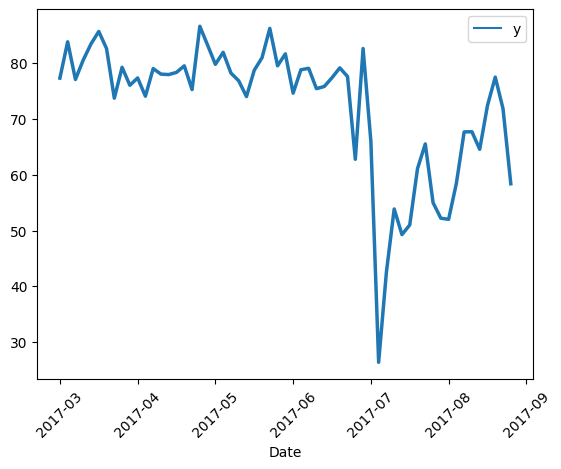

In [484]:
ax = sns.lineplot(data = data[['y', 'date_load']], palette = "tab10", linewidth = 2.5)
ax.set_xticklabels(data['date_load'], rotation=45)
ax.set_xlabel('Date')
plt.show()

In [485]:
# Seats data test

# assuming the dataframe is named "df"
seats_all = seats.groupby("date")["total_seats"].sum().reset_index()
seats_all.columns = ["date", "total_month_seats"]

seats["total_month_seats"] = seats.groupby("date")["total_seats"].transform("sum")
seats

,operating_airline,departure_country_iata,arrival_country_iata,total_seats,type,date,total_month_seats
477194,SY,US,PR,549,Leisure,2017-05,142686
477195,SY,US,CU,162,Leisure,2017-05,142686
477196,SY,MX,US,3693,Leisure,2017-05,142686
477197,SY,CA,US,324,Leisure,2017-05,142686
477198,SY,US,DO,494,Leisure,2017-05,142686
...,...,...,...,...,...,...,...
478255,SY,US,BZ,549,Leisure,2022-12,505167
478256,SY,US,TC,678,Leisure,2022-12,505167
478257,SY,MX,US,20769,Leisure,2022-12,505167
478258,SY,US,MX,21138,Leisure,2022-12,505167


C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\1803572155.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(seats['date'], rotation=45)


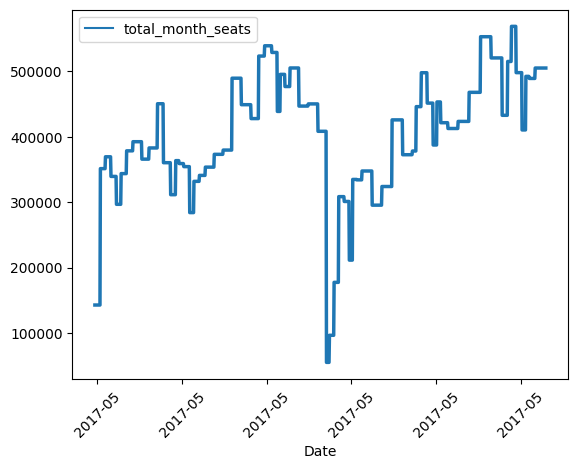

In [486]:
ax = sns.lineplot(data = seats[['total_month_seats', 'date']], palette = "tab10", linewidth = 2.5)
ax.set_xticklabels(seats['date'], rotation=45)
ax.set_xlabel('Date')
plt.show()

C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\2966813059.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=data[['y', 'date_load']], x='date_load', y='y', palette="tab10", linewidth=2.5, ax=ax1)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\2966813059.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=seats[['total_month_seats', 'date']], x='date', y='total_month_seats', palette="tab10", linewidth=2.5, ax=ax2)


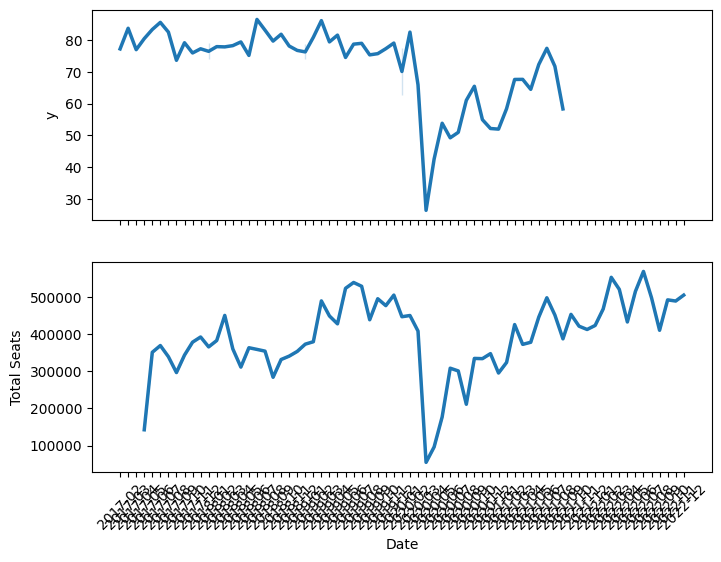

In [487]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))

# plot the first lineplot in the first subplot
sns.lineplot(data=data[['y', 'date_load']], x='date_load', y='y', palette="tab10", linewidth=2.5, ax=ax1)
ax1.set_ylabel('y')

# plot the second lineplot in the second subplot
sns.lineplot(data=seats[['total_month_seats', 'date']], x='date', y='total_month_seats', palette="tab10", linewidth=2.5, ax=ax2)
ax2.set_ylabel('Total Seats')

# set the x-label to be shared between the two subplots
plt.xlabel('Date')

# rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

plt.show()

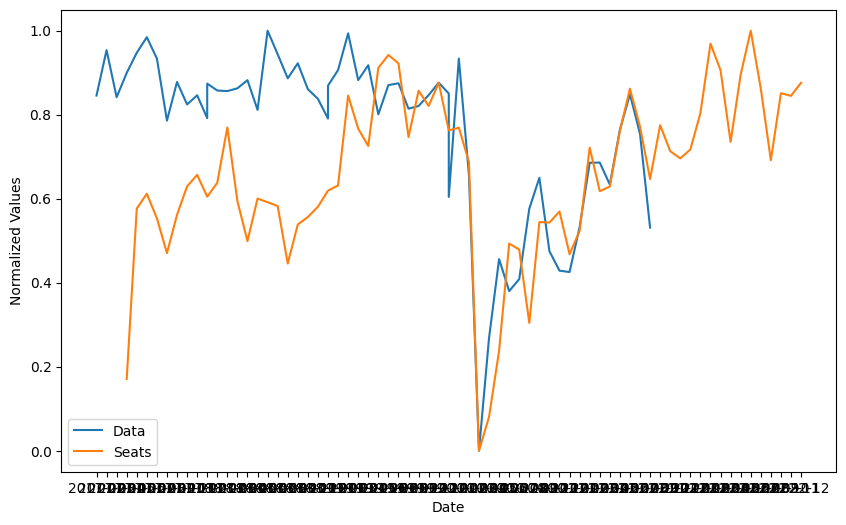

In [488]:
# Normalize data
data_norm = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())
seats_norm = (seats['total_month_seats'] - seats['total_month_seats'].min()) / (seats['total_month_seats'].max() - seats['total_month_seats'].min())

# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data['date_load'], data_norm, label='Data')
ax.plot(seats['date'], seats_norm, label='Seats')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Values')
ax.legend()

plt.show()

In [489]:
data = data.rename({'date_load':'date'}, axis=1)
data

# merged_df = pd.merge(seats, data, left_on='date')
merged_df = pd.merge(seats, data, on='date')
merged_df.drop('operating_airline',axis=1).drop('departure_country_iata', axis=1).drop('arrival_country_iata', axis=1)
# merged_df

,total_seats,type,date,total_month_seats,organization_code_iata,organization_code_icao,accounting_period,y,continuous,covid,cap,floor
0,549,Leisure,2017-05,142686,SY,SCX,Month 5,80.523211,4,False,100,0
1,162,Leisure,2017-05,142686,SY,SCX,Month 5,80.523211,4,False,100,0
2,3693,Leisure,2017-05,142686,SY,SCX,Month 5,80.523211,4,False,100,0
3,324,Leisure,2017-05,142686,SY,SCX,Month 5,80.523211,4,False,100,0
4,494,Leisure,2017-05,142686,SY,SCX,Month 5,80.523211,4,False,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...
863,4227,Leisure,2021-09,387453,SY,SCX,Month 9,58.366363,56,False,100,0
864,183,Leisure,2021-09,387453,SY,SCX,Month 9,58.366363,56,False,100,0
865,2013,Leisure,2021-09,387453,SY,SCX,Month 9,58.366363,56,False,100,0
866,4227,Leisure,2021-09,387453,SY,SCX,Month 9,58.366363,56,False,100,0


In [490]:
# sns.lineplot(data=merged_df, x='date', y='total_month_seats')
# sns.lineplot(data=merged_df, x='date', y='y')
# plt.show()

In [491]:
# Define a function to normalize a given column
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

# Apply the function to the 'total_month_seats' and 'y' columns
merged_df['total_month_seats_normalized'] = normalize(merged_df['total_month_seats'])
merged_df['y_normalized'] = normalize(merged_df['y'])



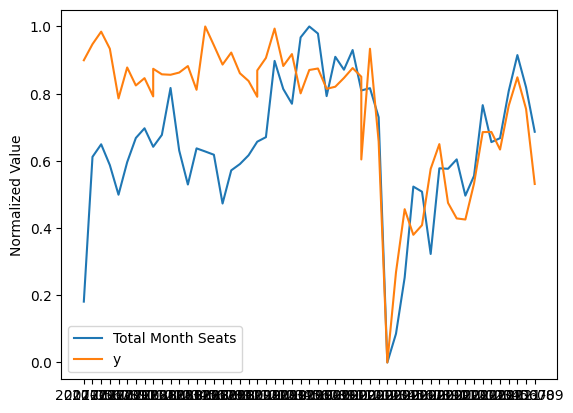

In [492]:
# plot the normalised total_month_seats column
plt.plot(merged_df['date'], merged_df['total_month_seats_normalized'], label='Total Month Seats')

# plot the normalised y column
plt.plot(merged_df['date'], merged_df['y_normalized'], label='y')

# add a legend
plt.legend()

# set the y-axis label
plt.ylabel('Normalized Value')

# display the plot
plt.show()


In [493]:
# Add country of origin
aircon = pd.read_csv('airline_country.csv')

# create a dictionary mapping iata codes to iso codes
origin = dict(zip(aircon['airline'], aircon['country_covid']))
# create a new column 'origin' in the merged dataframe, with values from the origin dictionary
merged_df['origin'] = merged_df['operating_airline'].map(origin)

# Add another column with the country IATA
country = dict(zip(aircon['country_covid'], aircon['country']))
merged_df['country'] = merged_df['origin'].map(country)

# merged_df

In [494]:
import numpy as np
merged_df['flight_type'] = np.where(merged_df['departure_country_iata'] == merged_df['arrival_country_iata'], 'internal', 'external')

In [495]:
country = merged_df['origin'].iloc[1]
country

'United States'

In [496]:
df = pd.DataFrame()
covid = pd.read_csv('./data/covid.csv')

covid = covid[covid['location'] == country]
new_df = covid[['date', 'stringency_index']]

new_df['date'] = pd.to_datetime(new_df['date']).dt.strftime('%Y-%m')

new_df

C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\2790224367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date'] = pd.to_datetime(new_df['date']).dt.strftime('%Y-%m')


,date,stringency_index
148448,2020-01,0.00
148449,2020-01,0.00
148450,2020-01,0.00
148451,2020-01,0.00
148452,2020-01,0.00
...,...,...
149153,2021-12,51.21
149154,2021-12,51.20
149155,2021-12,51.19
149156,2021-12,51.18


In [497]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the stringency_index column
new_df['stringency_index_normalized'] = scaler.fit_transform(new_df[['stringency_index']])

# print the first few rows of the new_df dataframe
print(new_df.head())

           date  stringency_index  stringency_index_normalized
148448  2020-01               0.0                          0.0
148449  2020-01               0.0                          0.0
148450  2020-01               0.0                          0.0
148451  2020-01               0.0                          0.0
148452  2020-01               0.0                          0.0


C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\3205916220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['stringency_index_normalized'] = scaler.fit_transform(new_df[['stringency_index']])


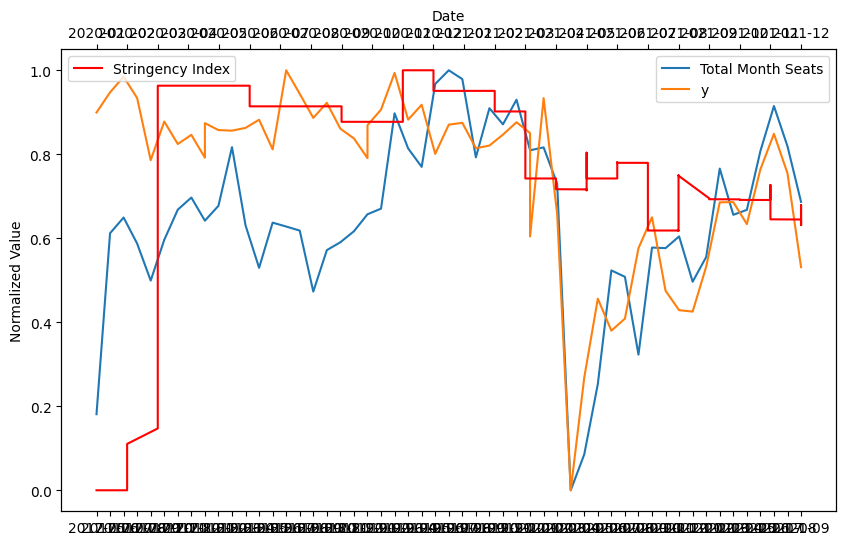

In [498]:
# create a new figure and set the size
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot the normalised total_month_seats column
ax1.plot(merged_df['date'], merged_df['total_month_seats_normalized'], label='Total Month Seats')

# plot the normalised y column
ax1.plot(merged_df['date'], merged_df['y_normalized'], label='y')

# set the y-axis label
ax1.set_ylabel('Normalized Value')

# create a twin Axes sharing the x-axis
ax2 = ax1.twiny()

# plot the stringency_index column on the twin axis
ax2.plot(new_df['date'], new_df['stringency_index_normalized'], label='Stringency Index', color='red')

# set the x-axis label for the twin axis
ax2.set_xlabel('Date')

# add a legend for the twin axis
ax2.legend(loc='upper left')

# add a legend for the primary axis
ax1.legend(loc='upper right')

# display the plot
# plt.show()

In [499]:
merged_df.to_csv('first_merged_csv.csv')

In [500]:
df = pd.merge(merged_df, new_df, on='date')
df

,operating_airline,departure_country_iata,arrival_country_iata,total_seats,type,date,total_month_seats,organization_code_iata,organization_code_icao,accounting_period,...,covid,cap,floor,total_month_seats_normalized,y_normalized,origin,country,flight_type,stringency_index,stringency_index_normalized
0,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
1,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
2,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
3,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
4,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9659,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.31,0.693215
9660,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.31,0.693215
9661,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.30,0.693082
9662,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.30,0.693082


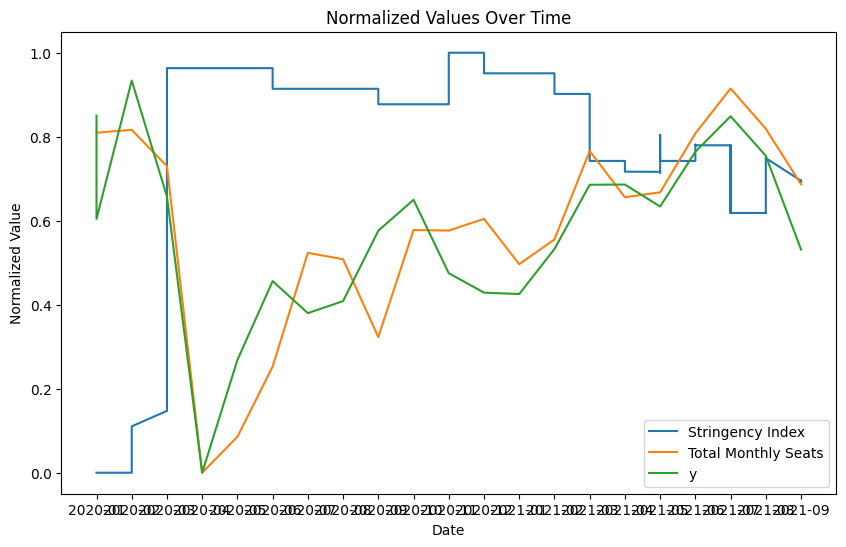

In [501]:
# create a figure and axis objects
fig, ax = plt.subplots(figsize=(10,6))

# plot the three columns against the date column
ax.plot(df['date'], df['stringency_index_normalized'], label='Stringency Index')
ax.plot(df['date'], df['total_month_seats_normalized'], label='Total Monthly Seats')
ax.plot(df['date'], df['y_normalized'], label='y')

# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Value')
ax.set_title('Normalized Values Over Time')

# add legend
ax.legend()

# show the plot
plt.show()

In [505]:
df.to_csv('single_data.csv')
df

,operating_airline,departure_country_iata,arrival_country_iata,total_seats,type,date,total_month_seats,organization_code_iata,organization_code_icao,accounting_period,...,covid,cap,floor,total_month_seats_normalized,y_normalized,origin,country,flight_type,stringency_index,stringency_index_normalized
0,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
1,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
2,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
3,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
4,SY,US,DO,2745,Leisure,2020-01,446967,SY,SCX,Month 1,...,False,100,0,0.809553,0.850467,United States,US,external,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9659,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.31,0.693215
9660,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.31,0.693215
9661,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.30,0.693082
9662,SY,US,PR,183,Leisure,2021-09,387453,SY,SCX,Month 9,...,False,100,0,0.686640,0.531231,United States,US,external,52.30,0.693082


0    846
1     22
Name: y, dtype: int64


C:\Users\Oscar\AppData\Local\Temp\ipykernel_14544\3963070172.py:54: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  span = SpanSelector(ax[0], update_plot, 'horizontal', useblit=True, rectprops=dict(alpha=0.5, facecolor='red'))


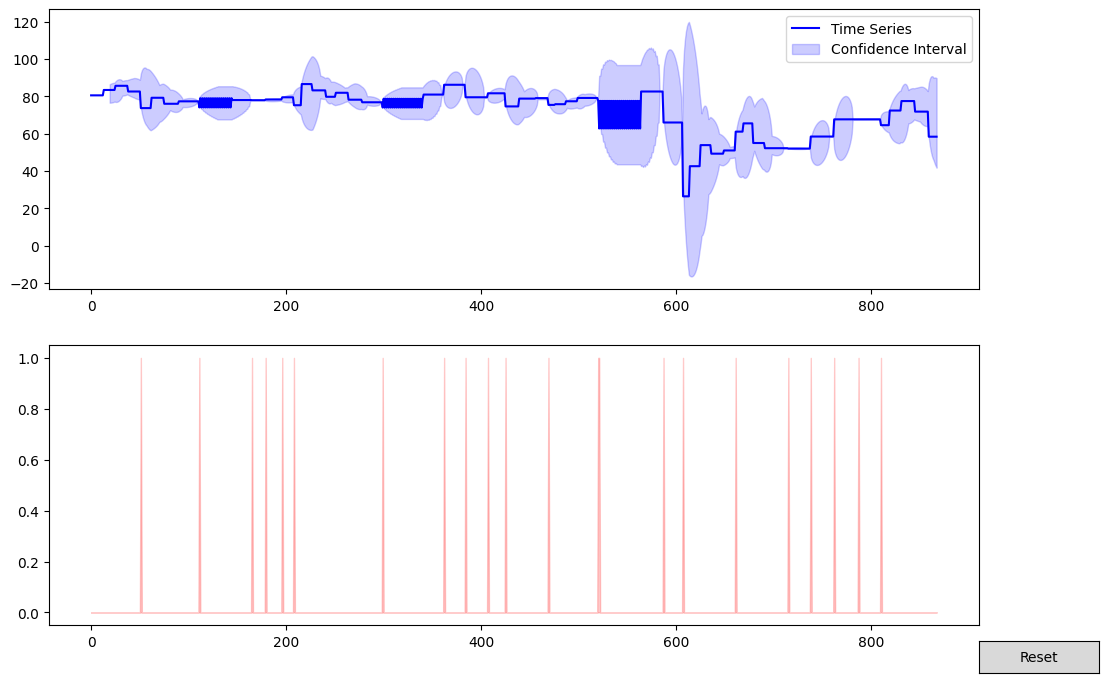

In [503]:
from matplotlib.widgets import SpanSelector

# Define rolling confidence interval function
def rolling_confidence_interval(data, window_size, std_multiplier):
    """
    Calculates rolling mean, standard deviation, upper and lower bounds.
    """
    rolling_mean = data.rolling(window_size).mean()
    rolling_std = data.rolling(window_size).std()
    upper_bound = rolling_mean + (rolling_std * std_multiplier)
    lower_bound = rolling_mean - (rolling_std * std_multiplier)
    return upper_bound, lower_bound

def update_plot(xmin, xmax):
    ax[0].set_xlim(xmin, xmax)
    ax[1].set_xlim(xmin, xmax)
    plt.draw()

def reset_zoom(event):
    ax[0].set_xlim(data.index[0], data.index[-1])
    ax[1].set_xlim(data.index[0], data.index[-1])
    plt.draw()

# Load data
data = pd.read_csv('first_merged_csv.csv')
data = data['y']

# Calculate rolling confidence interval with 3 standard deviations
upper_bound, lower_bound = rolling_confidence_interval(data, window_size=20, std_multiplier=3.5)

# Create a boolean column for breakouts
breakout = ((data > upper_bound) | (data < lower_bound)).astype(int)
# breakout.replace({0: np.nan, 1: 0}, inplace=True)
print(breakout.value_counts())
breakout.fillna(method='ffill', inplace=True)

# Plot time series and confidence interval
fig, ax = plt.subplots(2, 1, figsize=(12,8))

# print(data)

ax[0].plot(data, color='blue', label='Time Series')
ax[0].fill_between(data.index, upper_bound, lower_bound, alpha=0.2, color='blue', label='Confidence Interval')
ax[0].legend()

# Plot red highlights for breakouts
ax[1].fill_between(data.index, 0, breakout, alpha=0.2, color='red')

# Add reset button
reset_button_ax = plt.axes([0.9, 0.05, 0.1, 0.04])
reset_button = plt.Button(reset_button_ax, 'Reset')
reset_button.on_clicked(reset_zoom)

span = SpanSelector(ax[0], update_plot, 'horizontal', useblit=True, rectprops=dict(alpha=0.5, facecolor='red'))

plt.show()